Based on the work of: Abid Ali Awan

An Introduction to Q-Learning: A Tutorial For Beginners
Learn about the most popular model-free reinforcement learning algorithm with a Python tutorial.

[Datacamp](https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial)



In [ ]:
!pip3 install pyglet==1.5.1
#!apt install python-opengl
!apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay


**Setup a Virtual Display**


*   We will first install all the dependencies to generate a replay video(Gif).
*   We will need a virtual screen (pyvirtualdisplay) to render the environment and record the frames.


In [ ]:

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

**Install dependencies**

We will now install dependencies that will help us create, run, and evaluate the training loop.

*   gym: Used to initialize the FrozenLake-v1 environment.
*   pygame: Used for the FrozenLake-v1 UI.
*   numPy: Used for creating and handling the Q-table.






In [ ]:
!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install imageio imageio_ffmpeg

**Import the packages**

We will now import the required libraries.

* Imageio is used for creating the animation.

* tqdm is used for progress bars.

In [2]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

**Frozen Lake Gym Environment **

We are going to create a non-slippery 4x4 environment using the Frozen Lake gym library.

* There are two grid versions, “4x4” and “8x8”.
* If the `is_slippery=True`, the agent may not move in the intended direction   due to the slippery nature of the frozen lake.

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

After initializing the environment, we will do an environmental analysis.

There are 16(or 64) unique spaces in the environment displayed at random positions.

In [20]:
env = gym.make("FrozenLake-v1",map_name="8x8",is_slippery=False)

print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # display a random observation

Observation Space Discrete(64)
Sample observation 32


**The action space:**

0: move left

1: move down

2: move right

3: move up

**Reward function:**

Reaching the goal: +1

Falling into the hole: 0

Staying on the frozen lake: 0



In [21]:
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 4
Action Space Sample 1


**Create and Initialize the Q-table**

The Q-Table has columns as actions, and rows as states. We can use OpenAI Gym to find action space and state space. We will then use this information to create the Q-Table.

In [22]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  64  possible states
There are  4  possible actions


For initializing the Q-Table, we will create a Numpy array of state_space and actions space. We will create a 64 X 4 array.

In [23]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

**Epsilon-greedy policy**

In the previous section, we have learned about the epsilon greedy strategy that handles exploration and exploitation tradeoffs. With a Probability of 1 - ɛ, we do exploitation, and with the probability ɛ, we do exploration.

In the epsilon_greedy_policy we will:

1. Generate the random number between 0 to 1.
2. If the random number is greater than epsilon, we will do **exploitation**. It means that the agent will take the action with the highest value given a state.
3. Else, we will do **exploration** (Taking random action).

In [24]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

## **Define the greedy policy**

As we now know that Q-learning is an off-policy algorithm which means that the policy of taking action and updating function is different.

In this example, the Epsilon Greedy policy is acting policy, and the Greedy policy is updating policy.

The Greedy policy will also be the final policy when the agent is trained. It is used to select the highest state and action value from the Q-Table.

In [25]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

## **Model hyperparameters**

These hyperparameters are used in the training loop, and fine-tuning them will give you better results.

The Agent needs to explore enough state space to learn good value approximation; we need to have progressive decay of epsilon. If the decay rate is high, the agent might get stuck as it has not explored enough state space.

* There are 10,000 training and 100 evaluation episodes.
* The learning rate is 0.7.
* We are using "FrozenLake-v1" as an environment with 99 maximum steps per episode.
* The gamma (discount rate) is 0.95.
* eval_seed: evaluation seed for the environment.
* The exploration epsilon probability at the start is 1.0, and the minimum probability will be 0.05.
* The exponential decay rate for epsilon probability is 0.0005.

In [40]:
# Training parameters
n_training_episodes = 15000
learning_rate = 0.7

# Evaluation parameters
n_eval_episodes = 100

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 200
gamma = 0.95
eval_seed = []

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

Model Training

In the training loop, we will:

1. Create a loop for training episodes.
2. We will first reduce epsilon. As we need less and less exploration and more exploitation with every episode.
3. Reset the environment.
4. Create a nested loop for the maximum steps.
5. Choose the action using the epsilon greedy policy.
6. Take action (At) and observe the expected reward(Rt+1) and state(St+1).
7. Take the action (a) and observe the outcome state(s') and reward (r).
8. Update the Q-function using the formula.
9. If `done= True`, finish the episode and break the loop.
10. Finally, change the current state to a new state.
11. After completing all of the training episodes, the function will return the updated Q-Table.

In [41]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):

    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):

      action = epsilon_greedy_policy(Qtable, state, epsilon)


      new_state, reward, done, info = env.step(action)


      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break

      # Our state is the new state
      state = new_state
  return Qtable

In [42]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/15000 [00:00<?, ?it/s]

As we can see, the trained Q-Table has values, and the agent will now use these values to navigate the environment and achieve the goal.  

In [43]:
Qtable_frozenlake

array([[0.48767498, 0.51334208, 0.51334208, 0.48767498],
       [0.48767498, 0.54036009, 0.54036009, 0.51334208],
       [0.51334208, 0.56880009, 0.56880009, 0.54036009],
       [0.54036009, 0.59873694, 0.59873694, 0.56880009],
       [0.56880009, 0.63024941, 0.63024941, 0.59873694],
       [0.59873694, 0.66342043, 0.66342043, 0.63024941],
       [0.63024941, 0.6983373 , 0.6983373 , 0.66342043],
       [0.66342015, 0.73509189, 0.69833728, 0.6983373 ],
       [0.51334208, 0.54036009, 0.54036009, 0.48767498],
       [0.51334208, 0.56880009, 0.56880009, 0.51334208],
       [0.54036009, 0.59873694, 0.59873694, 0.54036009],
       [0.56880009, 0.        , 0.63024941, 0.56880009],
       [0.59873694, 0.66342043, 0.66342043, 0.59873694],
       [0.63024941, 0.6983373 , 0.6983373 , 0.63024941],
       [0.66342043, 0.73509189, 0.73509189, 0.66342043],
       [0.6983373 , 0.77378094, 0.73509189, 0.6983373 ],
       [0.54036009, 0.56880009, 0.56880009, 0.51334208],
       [0.54036009, 0.59873694,

## **Evaluation**

The evaluate_agent runs for `n_eval_episodes` episodes and returns the mean and standard deviation of the reward.

1. In the loop, we will first check if there is an evaluation seed. If not, then we will reset the environment without seed.
2. The nested loop will run to max_steps.
3. The agent will take the action that has the maximum expected future reward in a given state using Q-Table.
4. Calculate the reward.
5. Change the state.
6. If done (agent falls into the hole or goal has been achieved), break the loop.
7. Append the results.
8. In the end, we will use these results to calculate the mean and standard deviation.

In [44]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum reward
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

As you can see, we got the perfect score with zero standard deviation. It means that our agent has reached the goal in all 100 episodes.

In [45]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


## **Visualizing the result**

Till now, we have been playing with numbers, and to give the demo, we need to create an animated Gif of the agent from the start till it reaches the goal.

1. We will first create the state by resetting the environment with a random integer 0-500.
2. Render the environment using rdb_array to create an image array.
3. Then append the `img` to the `images` array.
4. In the loop, we will take the step using the Q-Table and render the image for every step.
5. In the end, we will use this array and imageio to create a Gif of one frame per second.

In [46]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

If you are in a Jupyter notebook, you can display the Gif using the `IPython.display` Image function.

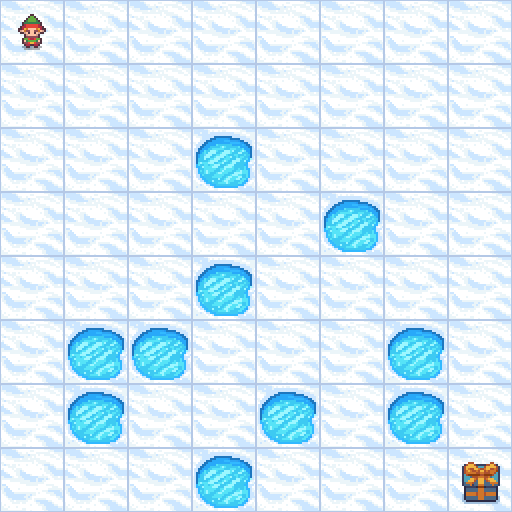

In [55]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')